(sec-ray-tune)=
# Ray Tune

Ray Tune 主要面向超参数调优场景，将模型训练、超参数选择和并行计算结合起来，它底层基于 Ray 的 Actor、Task 和 Ray Train，并行地启动多个机器学习训练任务，并选择最好的超参数。Ray Tune 适配了 PyTorch、Keras、XGBoost 等常见机器学习训练框架，提供了常见超参数调优算法（例如随机搜索、贝叶斯优化等）和工具（[Hyperopt](https://github.com/hyperopt/hyperopt)、[Optuna](https://github.com/optuna/optuna)等）。用户可以基于 Ray Tune 在 Ray 集群上进行批量超参数调优。读者可以阅读 {numref}`sec-hyperparameter-optimization`，重温超参数调优背景知识。

## 关键组件

Ray Tune 主要包括以下组件：

* 将原有的训练过程抽象为一个可训练的函数（Trainable）
* 定义需要搜索的超参数搜索空间（Search Space）
* 使用一些搜索算法（Search Algorithm）和调度器（Scheduler）并行训练和智能调度。

{numref}`fig-ray-tune-key-parts` 展示了适配 Ray Tune 的关键部分。用户创建一个 [`Tuner`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.Tuner.html)，`Tuner` 中包含了需要训练的 Trainable 函数、超参数搜索空间，用户选择搜索算法或者使用某种调度器。不同超参数组合组成了不同的试验，Ray Tune 根据用户所申请的资源和集群已有资源，并行训练。用户可对多个试验的结果进行分析。

```{figure} ../img/ch-ray-ml/ray-tune-key-parts.svg
---
width: 600px
name: fig-ray-tune-key-parts
---
Ray Tune 关键部分
```

## Trainable

跟其他超参数优化库一样，Ray Tune 需要一个优化目标（Objective），它是 Ray Tune 试图优化的方向，一般是一些机器学习训练指标，比如模型预测的准确度等。Ray Tune 用户需要将优化目标封装在可训练（Trainable）函数中，可在原有单节点机器学习训练的代码上进行改造。Trainable 函数接收一个字典式的配置，字典中的键是需要搜索的超参数。在 Trainable 函数中，优化目标以 `ray.train.report(...)` 方式存储起来，或者作为 Trainable 函数的返回值直接返回。例如，如果用户想对超参数 `lr` 进行调优，优化目标为 `score`，除了必要的训练代码外，Trainable 函数如下所示：

```python
def trainable(config):
    lr = config["lr"]
    
    # 训练代码 ...
    
    # 以 ray.train.report 方式返回优化目标
    ray.train.report({"score": ...})
    # 或者使用 return 或 yield 直接返回
    return {"score": ...}
```

### 案例：图像分类

对图像分类案例进行改造，对 `lr` 和 `momentum` 两个超参数进行搜索，Trainable 函数是代码中的 `train_mnist()`：

In [2]:
import os
import tempfile

import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from ray import tune
from ray.tune.schedulers import ASHAScheduler

import ray
import ray.train.torch
from ray.train import Checkpoint

In [3]:
data_dir = os.path.join(os.getcwd(), "../data")

def train_func(model, optimizer, criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

def train_mnist(config):
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
         torchvision.transforms.Normalize((0.5,), (0.5,))]
    )

    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform),
        batch_size=128,
        shuffle=True)
    test_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    # 训练 10 个 epoch
    for epoch in range(10):
        train_func(model, optimizer, criterion, train_loader)
        acc = test_func(model, test_loader)

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (epoch + 1) % 5 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            ray.train.report({"mean_accuracy": acc}, checkpoint=checkpoint)

Ray Tune 同时支持使用函数方式和类方式定义 Trainable，本例中使用函数方式，函数方式和类方式的区别如 {numref}`tab-function-class-trainable` 所示。

```{table} 函数方式和类方式定义 Trainable 的区别
:name: tab-function-class-trainable
|      内容       |                函数方式 API                 |                 类方式 API                  |
| :----------------: | :----------------------------------------: | :----------------------------------------: |
| 一次训练迭代 | 每调用一次 `train.report`，迭代次数加一      | 每调用一次 `Trainable.step()`，迭代次数加一    |
| 反馈性能指标 | 调用 `train.report(metrics)`                     | 在 `Trainable.step()` 的返回值处返回       |
| 写入 Checkpoint | 调用 `train.report(..., checkpoint=checkpoint)`  | 实现 `Trainable.save_checkpoint()`                |
| 读取 Checkpoint| 调用 `train.get_checkpoint()`                   | 实现 `Trainable.load_checkpoint()`                |
| 读取不同的超参数组合   | `def train_func(config):` 中的 `config` 传入 | `Trainable.setup(self, config)` 中的 `config` 传入 |
```

## 搜索空间

搜索空间是超参数可能的值，Ray Tune 提供了一些方法定义搜索空间。比如，[`ray.tune.choice()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.sample_from.html) 从某个范围中选择可能的值，[`ray.tune.uniform()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.uniform.html) 从均匀分布中选择可能的值。现在对 `lr` 和 `momentum` 两个超参数设置搜索空间：

In [4]:
search_space = {
    "lr": tune.choice([0.001, 0.002, 0.005, 0.01, 0.02, 0.05]),
    "momentum": tune.uniform(0.1, 0.9),
}

## 搜索算法和调度器

Ray Tune 的超参数搜索中，核心概念是搜索算法和调度器。搜索算法负责从搜索空间中选择超参数组合进行试验；调度器则终止表现不佳的试验，以节省计算资源。搜索算法是必需的，而调度器则不必需。例如，可以结合使用随机搜索和 ASHA 调度器，让调度器对一些表现不佳的试验予以终止。

此外，一些超参数优化库如 [Hyperopt](https://github.com/hyperopt/hyperopt)、[Optuna](https://github.com/optuna/optuna) 等，通常提供了封装好的搜索算法，某些库还提供了调度器，这些库有其特定的使用方式。Ray Tune 封装了这些库，以统一不同库的使用体验。

以下是使用随机搜索的示例：

In [5]:
trainable_with_gpu = tune.with_resources(train_mnist, {"gpu": 1})

tuner = tune.Tuner(
    trainable_with_gpu,
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=41485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-20-25/train_mnist_421ef_00000_0_lr=0.0020,momentum=0.2905_2024-04-11_21-20-26/checkpoint_000000)
(train_mnist pid=41485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-20-25/train_mnist_421ef_00000_0_lr=0.0020,momentum=0.2905_2024-04-11_21-20-26/checkpoint_000001)
2024-04-11 21:24:22,692	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHE

调度器会分析每个试验的表现，并采用早停（Early Stopping）策略提前结束效果较差的试验，以节省计算资源，将资源分配给最有希望的试验。下面的例子使用了 [ASHA 算法](https://openreview.net/forum?id=S1Y7OOlRZ) {cite}`li2018Massively` 进行调度。

在前面的例子中，没有设置 [`ray.tune.TuneConfig`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.TuneConfig.html)，默认情况下只进行一次试验。接下来，我们设置 `ray.tune.TuneConfig` 中的 `num_samples` 参数，该参数定义了要运行的试验次数。同时，使用 [ray.tune.schedulers.ASHAScheduler](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.ASHAScheduler.html) 来终止性能较差的试验，将资源留给更有希望的试验。`ASHAScheduler` 的参数 `metric` 和 `mode` 定义了优化的指标和方向，本例中目标是最大化 "mean_accuracy"。

In [6]:
tuner = tune.Tuner(
    trainable_with_gpu,
    tune_config=tune.TuneConfig(
        num_samples=16,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=41806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00002_2_lr=0.0020,momentum=0.4789_2024-04-11_21-24-22/checkpoint_000000)
(train_mnist pid=42212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00005_5_lr=0.0050,momentum=0.8187_2024-04-11_21-24-22/checkpoint_000000) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_mnist pid=41806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00002_2_lr=0.0020,momentum=0.4789_2024-04-11_21-24-22/checkpoint_000001)
(train_mnist pid=41809) Checkpoint succes

2024-04-11 21:34:30,051	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-11 21:34:30,067	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22' in 0.0224s.
2024-04-11 21:34:30,083	INFO tune.py:1048 -- Total run time: 607.32 seconds (607.25 seconds for the tuning loop).


在训练过程中，屏幕上会打印出每个试验所选择的超参数值和目标。对于性能较差的试验，在经过几轮迭代之后，会采取早停策略。我们对这些试验的结果进行可视化：

Text(0, 0.5, 'Mean Accuracy')

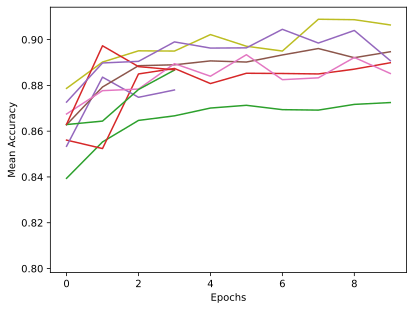

In [7]:
%config InlineBackend.figure_format = 'svg'

dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")

以上为 Ray Tune 的完整案例，接下来我们展示几个使用不同搜索算法和调度器的案例。

## 案例：飞机延误预测

这个例子基于飞机起降数据，使用 XGBoost 对是否延误进行预测。XGBoost 作为一个树模型，其训练过程的超参数包括树深度等。

In [ ]:
import os
import tempfile

import sys
sys.path.append("..")
from utils import nyc_flights

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18

import ray
from sklearn.model_selection import train_test_split
from ray.tune.search.hyperopt import HyperOptSearch
import xgboost as xgb
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.tune.schedulers import PopulationBasedTraining

folder_path = nyc_flights()
file_path = os.path.join(folder_path, "nyc-flights", "1991.csv")

读取数据，进行必要的数据预处理：

In [ ]:
input_cols = [
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "ActualElapsedTime",
    "Origin",
    "Dest",
    "Distance",
    "Diverted",
    "ArrDelay",
]

df = pd.read_csv(file_path, usecols=input_cols,)

# 预测是否延误
df["ArrDelayBinary"] = 1.0 * (df["ArrDelay"] > 10)

df = df[df.columns.difference(["ArrDelay"])]

for col in df.select_dtypes(["object"]).columns:
    df[col] = df[col].astype("category").cat.codes.astype(np.int32)

for col in df.columns:
    df[col] = df[col].astype(np.float32)

XGBoost `train()` 函数的 `params` 参数接收树深度等超参数。需要注意的是，XGBoost 等训练框架提供的 `train()` 函数不像 PyTorch 那样有 `for epoch in range(...)` 这样的显式迭代训练过程，如果希望每次训练迭代后立即反馈性能指标，需要在 `train()` 的 `callbacks` 中传入回调函数，Ray 提供了 [`TuneReportCheckpointCallback`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.integration.xgboost.TuneReportCheckpointCallback.html)，这个回调函数会在每次训练迭代后将相关指标报告给 Ray Tune。具体到本例中，XGBoost 的 `train()` 函数的 `params` 参数传入了 `"eval_metric": ["logloss", "error"]`，表示评估时的指标； `evals=[(test_set, "eval")]` 表示只关注验证集的指标；以上两者合起来，表示对验证集计算 `logloss` 和 `error` 指标，汇报给 Ray Tune 时，指标名称为 `eval-logloss` 和 `eval-error`。

In [ ]:
def train_flight(config: dict):
    config.update({
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"]
    })
    _y_label = "ArrDelayBinary"
    train_x, test_x, train_y, test_y = train_test_split(
        df.loc[:, df.columns != _y_label], 
        df[_y_label], 
        test_size=0.25
    )
    
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)
    
    xgb.train(
        params=config,
        dtrain=train_set,
        evals=[(test_set, "eval")],
        verbose_eval=False,
        # 每次迭代后， `TuneReportCheckpointCallback` 将评估指标反馈给 Ray Tune
        callbacks=[TuneReportCheckpointCallback(frequency=1)]
    )

我们底层使用 `hyperopt` 包所提供的贝叶斯优化搜索算法，如果没安装这个包，请先安装：`pip install hyperopt`。这些包通常有自己的定义搜索空间格式，用户也可以直接使用 Ray Tune 提供的搜索空间定义方式。

调度器方面，我们使用 Hyperband 调度算法。[`AsyncHyperBandScheduler`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.AsyncHyperBandScheduler.html) 是 Ray Tune 推荐的 Hyperband 算法的实现，它是异步的，能够更充分利用计算资源。`AsyncHyperBandScheduler` 中 `time_attr` 是描述训练时间的单位，默认为 `training_iteration`，表示一次训练迭代周期所需时间，`time_attr` 是计算资源额度的基本时间单位。`AsyncHyperBandScheduler` 的其他参数与 `time_attr` 规定的时间单位高度相关，比如 `max_t` 是每个试验所能获得的总时间，即一个试验最多能获得 `max_t` * `time_attr` 的计算资源额度；`grace_period` 表示至少给每个试验 `grace_period` * `time_attr` 的计算资源额度。`reduction_factor` 是 {numref}`sec-hyperparameter-optimization` 提到的 $\eta$，`brackets` 为 Hyperband 算法所涉及的组合的概念。

In [ ]:
search_space = {
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.choice([1, 2, 3]),
    "subsample": tune.uniform(0.5, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1),
}

scheduler = AsyncHyperBandScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=2,
    brackets=3,
)

tuner = tune.Tuner(
    train_flight,
    tune_config=tune.TuneConfig(
        metric="eval-error",
        mode="min",
        scheduler=scheduler,
        num_samples=16,
    ),
    param_space=search_space,
)
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (27 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_flight pid=46796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_flight_2024-04-17_23-23-05/train_flight_63737_00004_4_eta=0.0697,max_depth=1,min_child_weight=2,subsample=0.9087_2024-04-17_23-23-08/checkpoint_000000)
2024-04-17 23:23:16,344	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/train_flight_2024-04-17_23-23-05' in 0.0653s.
2024-04-17 23:23:16,362	INFO tune.py:1048 -- Total run time: 10.73 seconds (10.38 seconds for the tuning loop).


`Tuner.fit()` 会将所有试验的结果返回成 `ResultGrid` ，也会把各类信息写到持久化存储上，用户可以查看不同超参数下的效果并进行分析和对比：

In [ ]:
results_df = results.get_dataframe()
results_df[["eval-error", "training_iteration", "config/max_depth", "config/min_child_weight", "config/subsample"]]

eval-error  training_iteration  config/max_depth  config/min_child_weight  \
0     0.222878                  10                 2                        3   
1     0.219595                  10                 3                        3   
2     0.223699                   1                 3                        1   
3     0.176524                  10                 7                        1   
4     0.223466                  10                 1                        2   
5     0.223869                  10                 4                        2   
6     0.221360                   2                 5                        2   
7     0.223079                   1                 8                        3   
8     0.221159                   2                 5                        1   
9     0.223745                   2                 2                        3   
10    0.224070                   2                 8                        3   
11    0.223993                   1                 7                        1   
12    0.219904                   8                 1                        2   
13    0.223172                   1                 5                        2   
14    0.222444                   1                 2                        3   
15    0.221283                   2                 1                        1   

    config/subsample  
0           0.963344  
1           0.930057  
2           0.532473  
3           0.824932  
4           0.908686  
5           0.799064  
6           0.555629  
7           0.842890  
8           0.766606  
9           0.576874  
10          0.824537  
11          0.921332  
12          0.682057  
13          0.570677  
14          0.852950  
15          0.720122

## 案例：基于 PBT 进行图像分类

PBT 在训练过程中会对模型权重和超参数都进行调整，因此其训练代码部分必须有更新（加载）模型权重的代码。在传统的 PyTorch 训练中，通常会有 `for epoch in range(...)` 这样的循环结构，并具有明确的终止条件。区别于通常的 PyTorch 训练，Ray Tune 的 PBT 的训练过程不设置显式的终止条件，而是用 `while True` 一直循环迭代，直到模型性能达到预期或执行早停策略，由 Ray Tune 来终止训练。

In [ ]:
data_dir = os.path.join(os.getcwd(), "../data")

def train_func(model, optimizer, criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [ ]:
def train_mnist(config):
    step = 1
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
         torchvision.transforms.Normalize((0.5,), (0.5,))]
    )

    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform),
        batch_size=128,
        shuffle=True)
    test_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=config.get("lr", 0.01), 
        momentum=config.get("momentum", 0.9)
    )

    checkpoint = ray.train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
        
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        
        # 将 config 传进来的 lr 和 momentum 更新到优化器中 
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "momentum" in config:
                param_group["momentum"] = config["momentum"]
        
        last_step = checkpoint_dict["step"]
        step = last_step + 1
    
    # Ray Tune 会根据性能指标终止试验
    while True:
        train_func(model, optimizer, criterion, train_loader)
        acc = test_func(model, test_loader)
        metrics = {"mean_accuracy": acc, "lr": config["lr"]}

        if step % config["checkpoint_interval"] == 0:
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(
                    {
                        "step": step,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    os.path.join(tmpdir, "checkpoint.pt"),
                )
                ray.train.report(metrics, checkpoint=ray.train.Checkpoint.from_directory(tmpdir))
        else:
            ray.train.report(metrics)

        step += 1

接下来使用 [PopulationBasedTraining](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.PopulationBasedTraining.html) 定义 PBT 调度器。`time_attr` 跟刚才提到的其他调度器一样，是一个时间单位。`perturbation_interval` 表示每隔一定时间对超参数进行一些变异扰动，生成新的超参数，通常与 `checkpoint_interval` 使用同一个值，因为超参数变异扰动的同时也将 Checkpoint 写入持久化存储，会带来额外的开销，因此这个值不宜设置得过频繁。PBT 算法从 `hyperparam_mutations` 里选择可能变异的值，`hyperparam_mutations` 是一个键值字典，里面的内容就是变异值。

In [ ]:
perturbation_interval = 5
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="mean_accuracy",
    mode="max",
    hyperparam_mutations={
        "lr": tune.uniform(0.0001, 1),
        "momentum": [0.8, 0.9, 0.99],
    },
)

接下来就可以进行训练了。我们需要给 PBT 设置停止的条件，本例是 `mean_accuracy` 达到 0.9 或一共完成 20 次迭代。

In [ ]:
tuner = tune.Tuner(
    tune.with_resources(train_mnist, {"gpu": 1}),
    run_config=ray.train.RunConfig(
        name="pbt_mnist",
        # 停止条件：`stop` 或者 `training_iteration` 两个条件任一先达到
        stop={"mean_accuracy": 0.9, "training_iteration": 20},
        checkpoint_config=ray.train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=4,
        ),
        storage_path="~/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=4,
    ),
    param_space={
        "lr": tune.uniform(0.001, 1),
        "momentum": tune.uniform(0.001, 1),
        "checkpoint_interval": perturbation_interval,
    },
)

results_grid = tuner.fit()

2024-04-17 18:03:53,880	INFO pbt.py:716 -- [pbt]: no checkpoint for trial train_mnist_817a7_00003. Skip exploit for Trial train_mnist_817a7_00001
2024-04-17 18:09:24,486	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-17 18:09:24,492	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/pbt_mnist' in 0.0111s.
2024-04-17 18:09:24,501	INFO tune.py:1048 -- Total run time: 455.82 seconds (455.74 seconds for the 

调优之后，就可以查看不同超参数的结果了，我们选择最优的那个结果，查看 `lr` 的变化过程。

Best result path: /home/u20200002/ray_results/pbt_mnist/train_mnist_817a7_00003_3_lr=0.1277,momentum=0.4868_2024-04-17_18-01-48
Best final iteration hyperparameter config:
 {'lr': 0.1277359940819796, 'momentum': 0.48679312797681595, 'checkpoint_interval': 5}


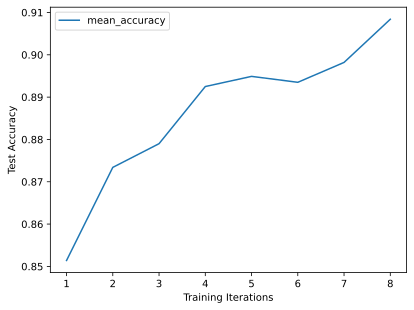

In [ ]:
%config InlineBackend.figure_format = 'svg'

best_result = results_grid.get_best_result(metric="mean_accuracy", mode="max")

print('Best result path:', best_result.path)
print("Best final iteration hyperparameter config:\n", best_result.config)

df = best_result.metrics_dataframe
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "mean_accuracy")
plt.xlabel("Training Iterations")
plt.ylabel("Test Accuracy")
plt.show()